In [1]:
hp = {}
hp['dataset'] = 'imagenet-full'
hp['desired_num_clusters'] = 1000
hp['num_merges_per_network_update'] = 3000

In [2]:
import json
from sklearn.metrics import roc_auc_score
from sklearn.cluster import AgglomerativeClustering
from torchvision import datasets
from twosample import utils
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter
from twosample import utils
import os
import itertools
import sklearn
from matplotlib.ticker import MaxNLocator

In [36]:
matplotlib.rcParams.update({'font.size': 22})
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amssymb}')
figure_path = 'figures/real'
utils.create_directory_if_not_exists(figure_path)

In [3]:
def run_evaluation(hp):
    experiment_directory = 'results/real/{}'.format(hp['dataset'])
    dataset = datasets.ImageFolder('./datasets/' + hp['dataset'])
     
    num_correct_merges = 0
    num_correct_merges_list = []
    for i in range(len(hp['checkpoints'])):
        # Load latest clustering checkpoint
        clustering_checkpoint = hp['checkpoints'][i]
        clustering_checkpoint_directory = experiment_directory + '/{}'.format(clustering_checkpoint)
        
        # Load clustering
        current_clustering_filename = clustering_checkpoint_directory + '/current_clustering.npy'
        print('Load train-test split from', current_clustering_filename)
        sample_indices_train, sample_indices_test = np.load(current_clustering_filename).tolist()
        current_clustering = [a + b for a, b in zip(sample_indices_train, sample_indices_test)]
        cluster_categories = [utils.get_majority_category(dataset, sample_indices)
                              for sample_indices in current_clustering]
        
        # Load mean arithmetic means in order to find best epoch
        mean_arithmetic_means_filename = clustering_checkpoint_directory + '/mean_arithmetic_means.csv'
        print('Load mean arithmetic means from', mean_arithmetic_means_filename)
        mean_arithmetic_means = np.loadtxt(mean_arithmetic_means_filename).tolist()
        print('mean arithmetic means:\n', mean_arithmetic_means)
        
        # Load affinities from epoch with highest mean arithmetic mean
        best_epoch = np.argmax(mean_arithmetic_means)
        print('Best epoch:', best_epoch)
        affinities_directory = clustering_checkpoint_directory + '/affinities'
        affinities_filename = affinities_directory + '/{}.npy'.format(best_epoch)
        print('Load affinities from', affinities_filename)
        affinities = np.load(affinities_filename)
        
        # Reproduce the merge process
        desired_num_clusters = hp['checkpoints'][i + 1] if i + 1 < len(hp['checkpoints']) else hp['desired_num_clusters']
        print('Merging from {} clusters to {} clusters.'.format(len(current_clustering),
                                                                desired_num_clusters))
        agglomerative_clustering = AgglomerativeClustering(linkage='average',
                                                           affinity='precomputed',
                                                           n_clusters=desired_num_clusters)
        agglomerative_clustering.fit(affinities)
        temp_clustering = {cluster_index: sample_indices for
                           cluster_index, sample_indices in enumerate(current_clustering)}
        counter = itertools.count(len(current_clustering))
        merge_history = [{'new_cluster': next(counter), 'cluster_a': x[0], 'cluster_b': x[1]}
                         for x in agglomerative_clustering.children_]

        print('Clustering complete.')
        for merge_step in merge_history:
            temp_clustering[merge_step['new_cluster']] = temp_clustering[merge_step['cluster_a']] +\
                                                         temp_clustering[merge_step['cluster_b']]
            num_correct_merges += utils.get_majority_category(dataset, temp_clustering[merge_step['cluster_a']]) ==\
                                  utils.get_majority_category(dataset, temp_clustering[merge_step['cluster_b']])
            num_correct_merges_list.append(num_correct_merges)
            del temp_clustering[merge_step['cluster_a']]
            del temp_clustering[merge_step['cluster_b']]
            if len(temp_clustering) == desired_num_clusters:
                break
        print(len(num_correct_merges_list))
    return num_correct_merges_list

In [4]:
hp['checkpoints'] = []
experiment_directory = 'results/real/{}'.format(hp['dataset'])
clustering_checkpoints = [int(clustering_checkpoint_directory)
                          for clustering_checkpoint_directory in os.listdir(experiment_directory)]
num_correct_merges_list_list = []
for clustering_checkpoint in sorted(clustering_checkpoints, reverse=True)[:-2]:
    hp['checkpoints'].append(clustering_checkpoint)
    print(hp['checkpoints'])
    num_correct_merges_list_list.append(run_evaluation(hp))
    print(len(num_correct_merges_list_list[-1]))

[8793]
Load train-test split from results/real/imagenet-full/8793/current_clustering.npy
Load mean arithmetic means from results/real/imagenet-full/8793/mean_arithmetic_means.csv
mean arithmetic means:
 [0.8437413573265076, 0.9576355218887329, 0.9778926372528076, 0.9857324957847595, 0.9835563898086548]
Best epoch: 3
Load affinities from results/real/imagenet-full/8793/affinities/3.npy
Merging from 8793 clusters to 1000 clusters.
Clustering complete.
7793
7793
[8793, 5793]
Load train-test split from results/real/imagenet-full/8793/current_clustering.npy
Load mean arithmetic means from results/real/imagenet-full/8793/mean_arithmetic_means.csv
mean arithmetic means:
 [0.8437413573265076, 0.9576355218887329, 0.9778926372528076, 0.9857324957847595, 0.9835563898086548]
Best epoch: 3
Load affinities from results/real/imagenet-full/8793/affinities/3.npy
Merging from 8793 clusters to 5793 clusters.
Clustering complete.
3000
Load train-test split from results/real/imagenet-full/5793/current_clus

1608 1832 1.1393034825870647


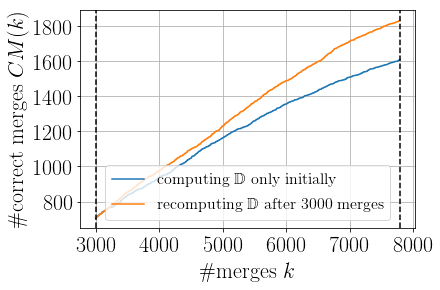

In [43]:
print(num_correct_merges_list_list[0][-1], num_correct_merges_list_list[1][-1],
      num_correct_merges_list_list[1][-1] / num_correct_merges_list_list[0][-1])

labels = ['computing $\mathbb{D}$ only initially',
          'recomputing $\mathbb{D}$ after 3000 merges']
for num_correct_merges_list in num_correct_merges_list_list:
    plt.plot(np.arange(hp['num_merges_per_network_update'], len(num_correct_merges_list)),
             num_correct_merges_list[hp['num_merges_per_network_update']:])
xposition = [hp['num_merges_per_network_update'],
             len(num_correct_merges_list)]
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.legend(labels, fontsize=16, loc=8)
plt.xlabel('\#merges $k$')
plt.ylabel('\#correct merges $CM(k)$')
plt.xticks(np.arange(3000, 9000, 1000))
plt.yticks(np.arange(800, 2000, 200))
plt.grid(True)
plt.savefig(figure_path + '/' +'real.pdf',
                bbox_inches='tight')
plt.show()